# Historical Consistent Neural Network

This notebook demonstrates how to Prosper_nn to build and analyze a Historical Consistent Neural Network (HCNN).
It begins with a basic HCNN and shows how the data and the training loop should look like and how to find suitable hyperparameters.
Then we build an ensemble of HCNNs for more reliable predictions and use it to show the uncertainty of the forecasts. The ensemble is also useful to investigate the influence of the input features on the future, which we also demonstrate.
Futhermore, we introduce the concept of Deep Historical Consistent Neural Networks and show how to build an ensemble of them.

## Theory

HCNNs belong to the class of Recurrent Neural Networks. The picture below shows the model. It can be used to forecast a time series. The architecture is special because it has no input in the common sense. All the data features are interpreted as targets that are equally important. So the architecture does not distinguish between input and output features. This is necessary because the forecasts depend on the future values of all features and therefore all features must be forecasted. This idea is common for Vector Autoregressive models.

The network has an internal state, which contains interpretable and uninterpretable features. The first part of the state vector is interpretable as it is the model's expectation of the target features. It is mapped to the target layer where the observed data features are subtracted. Because the target, i.e. this delta between model expectation and real observations, is equal to zero, the model learns to reconstruct the observables in the first part of the state vector. In other words, the result of the output layer corresponds to the absolute error between expectation and observation. 

The lower part of the state vector is uninterpretable and contains model-constructed hidden features. They are used to give the model more flexibility in capturing dynamics and influences which are unobserved.
To calculate the state of the next time step, a non-linearity ($\tanh$) and the state transition matrix $A$ are applied on the hidden state. These update steps describe the implementation of the HCNN Cell that calculates the output and the following state for one time step:
$$  s_{t+1} = A \tanh \left( s_t -[\mathbb{1}, 0]^T \cdot ( [\mathbb{1}, 0] s_t -y_t^d) \right)$$

$$ y_t = [\mathbb{1}, 0] \cdot s_t $$
Repeating the same cell in a row for following time steps gives the final HCNN.

<img src=images/hcnn.png width=1000 >

In [1]:
import sys, os

sys.path.append(os.path.abspath("../../.."))
sys.path.append(os.path.abspath(".."))
sys.path.append(os.path.abspath("."))

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter

from prosper_nn.models.hcnn import HCNN
from prosper_nn.models.ensemble import Ensemble
from prosper_nn.models.dhcnn import DHCNN

import prosper_nn.utils.generate_time_series_data as gtsd
import prosper_nn.utils.create_input_ecnn_hcnn as ci

import prosper_nn.utils.neuron_correlation_hidden_layers as nchl
import prosper_nn.utils.visualization as visualization
from prosper_nn.utils import visualize_forecasts
from prosper_nn.utils import sensitivity_analysis
torch.manual_seed(0)

## Data Preparation 

First, we set some parameters and create some dummy data. Most of these parameters are also relevant for the HCNN. For example, we have to set the length of the time series. On the one hand, we have to specify how many time steps in the past (`past_horizon`) we want to use to train our model. On the other hand, it is necessary to set the number of time steps the model should forecast (`forecast_horizon`). 

How many features the dataset should contain is determined with `n_features_Y` and the amount of observations that are trained in parallel in a batch is defined with `batchsize`. 

With `n_data` we specify the amount of time steps in the original time series. Sliding windows with the length `past_horizon` are extracted from this time series and are used for training.

In [3]:
past_horizon = 30
forecast_horizon = 5
n_features_Y = 2
batchsize = 1
n_batches = 2
n_data = 100

For HCNNs the data should be in the `shape=(past_horizon, batchsize, n_features_Y)`. Therefore, load a dummy data set and extract sliding windows out of it with the `create_input` function.

In [4]:
# generate data with "unknown" variables U
Y, U = gtsd.sample_data(n_data, n_features_Y=n_features_Y - 1, n_features_U=1)
Y = torch.cat((Y, U), 1)

# Only use Y as input for the hcnn
Y_batches = ci.create_input(
    Y=Y,
    past_horizon=past_horizon,
    batchsize=batchsize,
    forecast_horizon=forecast_horizon,
)

The targets of the HCNN should be in the same shape as the input data, that is `shape=(past_horizon, batchsize, n_features_Y)`. Because the output of the HCNN is already the comparison between oberservation and expectation in the past horizon, the targets are zeros.

In [5]:
targets = torch.zeros((past_horizon, batchsize, n_features_Y))

## Single Historical Consistent Neural Network (HCNN)

In this section, we show how to use a HCNN and start with the initialization. Then we discuss the training loop and create forecasts. At the end of the section we evaluate the model and analyze it.

### Initialization

First set the variables for the model initialization. Some variables depend on the data and are already specified above. One important hyperparameter is the size of the hidden state `n_state_neurons`. The `sparsity` should be chosen depending on `n_state_neurons`, because of the models numerical stability and long term memory. In big systems ($n\_state\_neurons > 50$) as a rule of thumb the following should apply: $sparsity \cdot n\_state\_neurons \approx 50$.

With the parameter `lstm` we can choose the type of cell that is used to calculate one update step. If we set it to `False` (default), the [HCNNCell](../api/hcnn.rst#prosper_nn.models.hcnn.hcnn_cell.HCNNCell) is chosen as described in the [Theory](#Theory) section. If we set it to `True`, the [HCNN_LSTM_Cell](../api/hcnn.rst#prosper_nn.models.hcnn.hcnn_lstm_cell.HCNN_LSTM_Cell) is used. Instead of a single transition matrix $A$, the cell applies a version of Long Short-Term Memory. The model has the option to use the values of the previous state for the next state and achieves long term memory in this way. 

For further explanation, have a look at the documentation of the [HCNN](../api/hcnn.rst).

In [6]:
n_state_neurons = 3
sparsity = 0
lstm = False

In [7]:
hcnn_model = HCNN(
    n_state_neurons=n_state_neurons,
    n_features_Y=n_features_Y,
    past_horizon=past_horizon,
    forecast_horizon=forecast_horizon,
    sparsity=sparsity,
    lstm=lstm,
)

Set optimizer and loss function.

In [8]:
optimizer = optim.Adam(hcnn_model.parameters(), lr=0.001)
loss_function = nn.MSELoss()

### Training Loop

The following code shows a training loop. The output of the HCNN has `shape=(past_horizon + forecast_horizon, batchsize, n_features_Y)`. The first `past_horizon` entries are already compared with the real observations and are equal to the absolut error. They are named `past_error` in the following and should be close to zero. The last `forecast_horizon` entries of the output didn't have that comparison and give the `forecast` directly.

For all time steps in `past_error`, the `loss` is calculated with the `loss_function`. The values are summed up and the `optimizer` reduces this value.

In [9]:
epochs = 100

total_loss = epochs * [0]
for epoch in range(epochs):
    for batch_index in range(0, Y_batches.shape[0]):
        hcnn_model.zero_grad()

        Y_batch = Y_batches[batch_index]
        model_output = hcnn_model(Y_batch)
        past_error, forecast = torch.split(model_output, past_horizon)

        losses = [loss_function(past_error[i], targets[i]) for i in range(past_horizon)]
        loss = sum(losses)
        loss.backward()
        optimizer.step()
        total_loss[epoch] += loss.detach()

### Forecast 
A final prediction with test data in the HCNN can be performed as shown:

In [10]:
with torch.no_grad():
    hcnn_model.eval()

    output_forecast = hcnn_model(Y_batches[0, :, 0].unsqueeze(1))
    forecast = output_forecast[past_horizon:]

### Evaluation
#### Postprocessing
Because the output of the model has different meaning for `past_horizon` and `forecast_horizon`, the `expected_timeseries` can be calculated by adding the real observation data `Y` on the `past_error` for the `past_horizon` and concatenate it to the `forecast` of the model. Then, we plot the `expected_timeseries`.

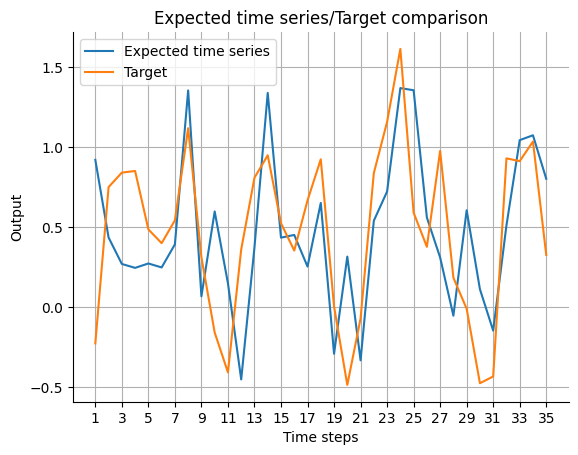

In [11]:
expected_timeseries = torch.cat(
    (torch.add(past_error.squeeze(), Y[:past_horizon]), forecast.squeeze()), dim=0
).detach()

visualize_forecasts.plot_time_series(
    expected_time_series=expected_timeseries[:, 0],
    target=Y[: past_horizon + forecast_horizon, 0],
)

#### Determine Dimension of Hidden State

We use [neuron correlation analysis](../api/neuron_correlation_hidden_layer.rst) to check the size of the hidden layer (= `n_state_neurons`). If there is a high correlation (>90%), two state perform more or less the same task. Therefore, the size of the state can be decreased. Further explanation can be found in the [Regression Flow Tutorial](Regression.ipynb#Determine-Hidden-Layer-Dimensionality).

For the analysis the hidden states have to be saved for all observations. So the forward path of the HCNN is repeated for all of them and the state is saved to the `states_for_correlation` tensor. The time step at which the state is saved is the present. Here the model should have the best possible state because it is the last time step where teacher forcing can be applied.

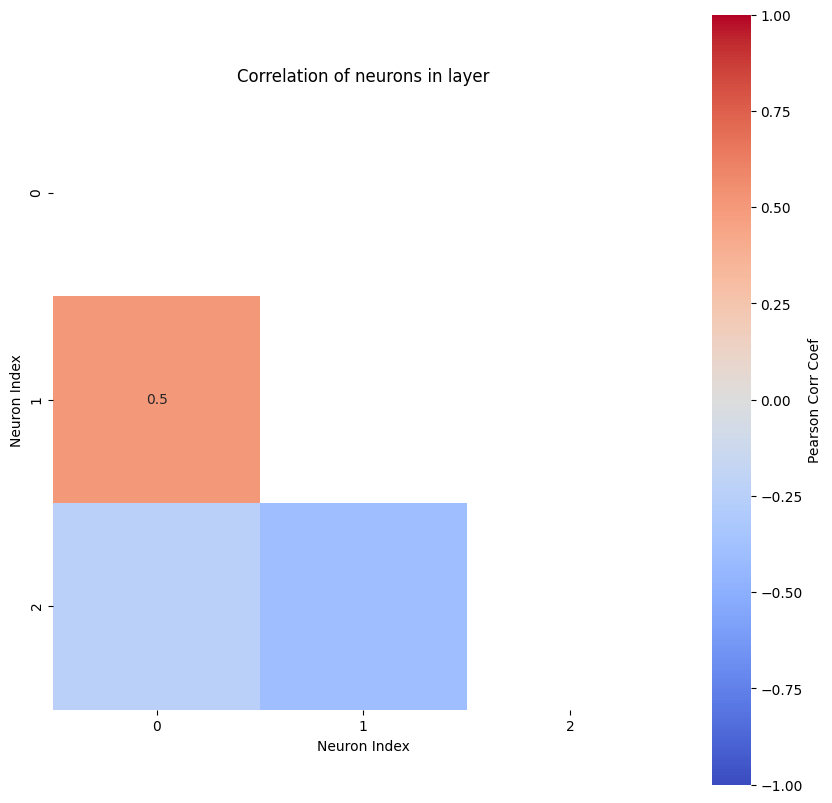

The most correlated neurons are the ones with indeces  [1, 0]
The according Pearson correlation coefficient is 0.5


In [12]:
with torch.no_grad():
    states_for_correlation = torch.empty(
        (Y_batches.shape[0], batchsize, n_state_neurons)
    )

    for batch_index in range(0, Y_batches.shape[0]):
        Y_batch = Y_batches[batch_index]
        model_output = hcnn_model(Y_batch)
        states_for_correlation[batch_index] = hcnn_model.state[past_horizon]
    states_for_correlation = states_for_correlation.reshape((-1, n_state_neurons))

    corr_matrix, max_corr, ind_neurons = nchl.hl_size_analysis(states_for_correlation)

## Ensemble of Historical Consistent Neural Networks

When the model trains well, we build an [Ensemble](../api/ensemble.rst) to further increase the performance. With this approach, the overparametrization is mitigated and the solution doesn't depend strongly on the start initialization like with a single model. 

### Initialization

We first have to choose the necessary parameters for the ensemble. The most interesting parameter is `n_models` that represents the number of submodels trained independently in the ensemble. When the original model has $sparsity>0$, the `sparsity` has to be given in the initialization because the submodels are independently pruned.

In [13]:
n_models = 3

Reset the HCNN.

In [14]:
hcnn_model = HCNN(
    n_state_neurons=n_state_neurons,
    n_features_Y=n_features_Y,
    past_horizon=past_horizon,
    forecast_horizon=forecast_horizon,
    sparsity=sparsity,
)

In [15]:
hcnn_ensemble = Ensemble(
    model=hcnn_model, n_models=n_models, sparsity=sparsity, combination_type="median"
)

Reset the optimizer.

In [16]:
optimizer = optim.Adam(hcnn_ensemble.parameters(), lr=0.001)

### Training Loop

The traing loop is similar to that of the single HCNN, but the output of the ensemble is of a different shape. The first n_models entries of the (additional) first dimension contain the output of the submodel HCNNs (`outputs`). The last entry of the first dimension contains the `mean` output of the submodels. We apply backpropagation on all the errors of the individual models for all time steps in the past horizon. The best prediction, though, is the mean of all these individual predicitions and therefore the `mean` output is used as final forecast and for loss calculation of the ensemble model.

In [17]:
epochs = 100

total_loss = epochs * [0]
for epoch in range(epochs):
    for batch_index in range(0, Y_batches.shape[0]):
        hcnn_ensemble.zero_grad()

        Y_batch = Y_batches[batch_index]
        ensemble_output = hcnn_ensemble(Y_batch)
        outputs, mean = torch.split(ensemble_output, n_models)
        mean = torch.squeeze(mean, 0)
        past_errors, forecasts = torch.split(outputs, past_horizon, dim=1)

        losses = [
            loss_function(past_errors[j][i], targets[i])
            for j in range(n_models)
            for i in range(past_horizon)
        ]
        loss = sum(losses) / (n_models * past_horizon)
        loss.backward()

        optimizer.step()

        mean_loss = (
            sum([loss_function(mean[i], targets[i]) for i in range(past_horizon)])
            / past_horizon
        )
        total_loss[epoch] += mean_loss.detach()

### Forecast 

A final forecast with test data using the ensemble HCNN can be performed as shown:

In [18]:
with torch.no_grad():
    hcnn_ensemble.eval()

    output_forecast = hcnn_ensemble(Y_batches[0, :, 0].unsqueeze(1))
    forecast = output_forecast[-1, past_horizon:]

### Evaluation

#### Visualization of Uncertainty

With an ensemble it is possible to visualize the uncertainty of the prediction. With the `plot_time_series` ([API](../api/visualize_forecasts.rst#prosper_nn.utils.visualize_forecasts.plot_time_series)) function the outputs of the individual models of the ensemble can be seen as uncertainty of the ensemble model. If the variance of the individual models is high, the mean output is rather uncertain, and vice versa. First, the `expected_timeseries` has to be calculated for the ensemble mean and the outputs of the individual submodels.

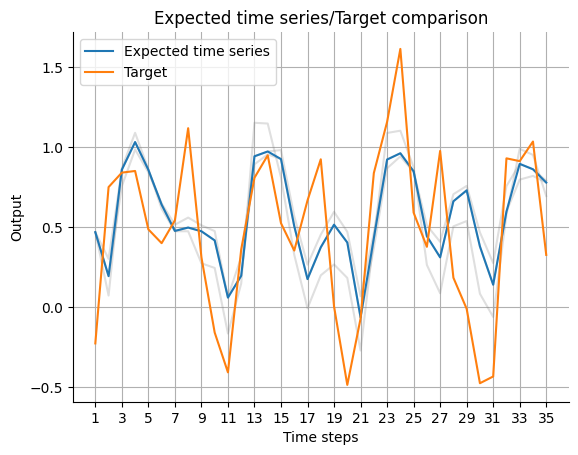

In [19]:
expected_timeseries = torch.cat(
    (torch.add(mean[:past_horizon], Y_batches[-1, :past_horizon]), mean[past_horizon:]),
    dim=0,
).detach()
expected_timeseries_outputs = torch.cat(
    (torch.add(past_errors, Y_batches[-1, :past_horizon]), forecasts), dim=1
).detach()

visualize_forecasts.plot_time_series(
    expected_time_series=expected_timeseries[:, 0, 0],
    target=Y[: past_horizon + forecast_horizon, 0],
    uncertainty=expected_timeseries_outputs[:, :, 0, 0].T,
)

#### Uncertainty Heatmap
A more advanced way of showing the uncertainty comes with the `heatmap_forecasts` ([API](../api/visualize_forecasts.rst#prosper_nn.utils.visualize_forecasts.heatmap_forecasts)) function. For each pixel in the image a heat is calculated that is higher if many forecasts are close in the vertical axis.

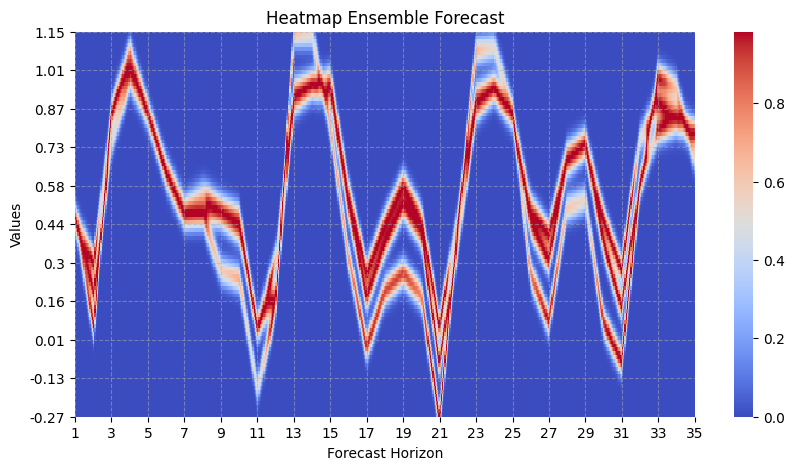

In [20]:
visualize_forecasts.heatmap_forecasts(expected_timeseries_outputs[:, :, 0, 0].T)

Due to runnability of this notebook, there's only a few models in the ensemble and they haven't been trained very well (e.g., small number of epochs). For a fully trained ensemble containing a larger number of models, the heat map look more like the following:

<img src=images/heatmap.png width=1000 >



Here, we see that the outputs of the individual models in the ensemble are spread out and where there is more variance and therefore uncertainty in the ensemble.

#### Sensitivity Analysis of the Input Features

The ensemble model can now be used to identify the important features of the dataset for forecasting. We apply the sensitivity analysis on the future nodes we are interested in. Then we have a look at the influence of the previous time steps. It can be interesting to find out when the values of the present have the most influence on the forecast.

Because the sensitivity analysis shows all features for all time steps, it is useful to restrict the analysis on one feature. The idea of the sensitivity analysis is described in more detail in the [Regression Tutorial](Regression.ipynb#Check-Input/Output-Sensitivity) and the [ECNN Tutorial](ECNN.ipynb#Sensitivity).

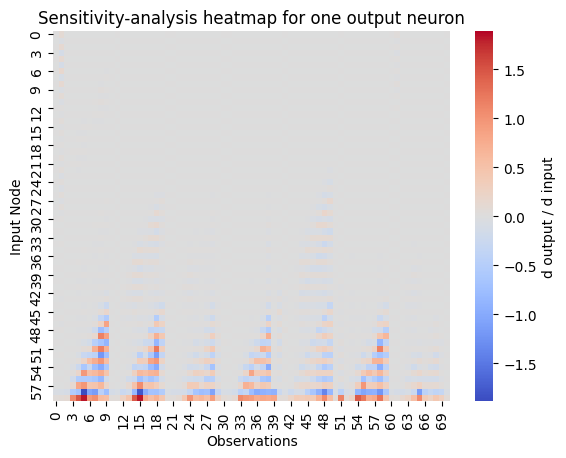

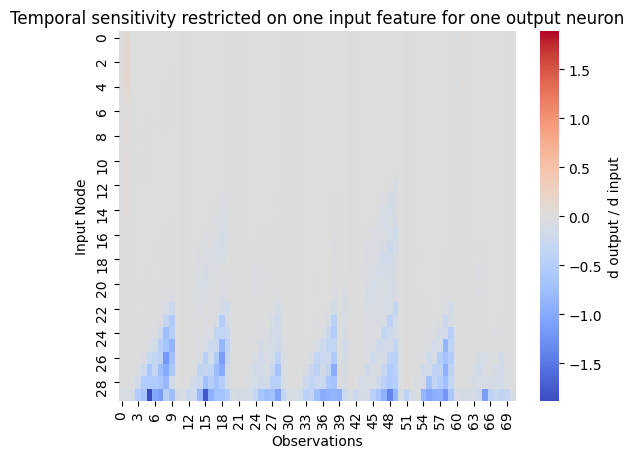

In [21]:
sensitivity = sensitivity_analysis.sensitivity_analysis(
    hcnn_ensemble,
    Y_batches[:, :past_horizon],
    output_neuron=(-1, past_horizon + 3, slice(0, batchsize), 0),
    batchsize=batchsize,
)

node_for_sensitivity = 0
restricted_sensitivity_matrix = sensitivity[
    :, range(node_for_sensitivity, past_horizon * n_features_Y, n_features_Y)
]
# plot
visualization.plot_heatmap(
    restricted_sensitivity_matrix.T,
    center=0,
    vmin=-torch.max(abs(sensitivity)),
    vmax=torch.max(abs(sensitivity)),
    xlabel="Observations",
    ylabel="Input Node",
    title="Temporal sensitivity restricted on one input feature for one output neuron",
    cbar_kws={"label": "d output / d input"},
)

## Deep Historical Consistent Neural Network (DHCNN)

Another possibility to improve HCNNs is to use a deep version of it, the [DHCNN](../api/dhcnn.rst). Multiple HCNNs are combined to solve the same task. The states of the lower level HCNNs are given to the upper levels. This way, the deeper levels have to explain only small errors in the state that the previous levels couldn't explain. Because of the additional levels and therefore additional matrices, the model gets even more over-parameterised when working with big state dimensions. Fortunately, it is enough to work with a small state dimension ($dim(state)\leq50$) and no sparsity in the matrices.  
The long term memory problem, which was previously tackled by the sparsity in the transition matrix, can then be solved by using a `HCNN_LSTM_CELL` ([API](../api/hcnn.rst#prosper_nn.models.hcnn.hcnn_lstm_cell.HCNN_LSTM_Cell)) in the lowest level of the DHCNN.
At the end, the deepest model gives the most reliable predictions.

<img src=images/deephcnn.png width=800 >

### Initialization

The `deepness` parameter is equal to the number of stacked HCNN models. As explained, we can decrease the hidden state dimension and need no sparsity.

In [22]:
deepness = 3
n_state_neurons = 50
sparsity = 0

In [23]:
dhcnn_model = DHCNN(
    n_state_neurons=n_state_neurons,
    n_features_Y=n_features_Y,
    past_horizon=past_horizon,
    forecast_horizon=forecast_horizon,
    deepness=deepness,
    sparsity=sparsity,
)

Reset the optimizer.

In [24]:
optimizer = optim.Adam(dhcnn_model.parameters(), lr=0.001)

### Training Loop

In the deep version of the HCNN there are some changings in the training loop. Because of the `deepness` we have an additional dimension in the `output` of the model. Now the shape of the output is `shape=(deepness, past_horizon+forecast_horizon, batchsize, n_features_Y)`. In the training we have to add the losses of all level of `deepness` and for all time steps in the `past_horizon`. Then this value is used for backpropagation. To compare the error of the model to others, we use the most reliable predictions from the deepest level. We receive it from the last level of the output: `output[-1]`.

In [25]:
epochs = 10

total_loss = epochs * [0]
for epoch in range(epochs):
    for batch_index in range(0, Y_batches.shape[0]):
        dhcnn_model.zero_grad()

        Y_batch = Y_batches[batch_index]
        output = dhcnn_model(Y_batch)
        past_error, forecast = torch.split(output, past_horizon, dim=1)

        losses = [
            loss_function(past_error[j][i], targets[i])
            for j in range(deepness)
            for i in range(past_horizon)
        ]
        loss = sum(losses) / (deepness * past_horizon)
        loss.backward()

        optimizer.step()

        loss_deepest_level = (
            sum([loss_function(output[-1, i], targets[i]) for i in range(past_horizon)])
            / past_horizon
        )
        total_loss[epoch] += loss_deepest_level.detach()

### Forecast 
As mentioned, the best prediction is in the deepest HCNN. Therefore, we will use this prediction as forecast.

In [26]:
with torch.no_grad():
    dhcnn_model.eval()

    output_forecast = dhcnn_model(Y_batches[0, :, 0].unsqueeze(1))
    forecast = output_forecast[-1, past_horizon:]


## Ensemble of Deep Historical Consistent Neural Network

Now we build an ensemble of the DHCNN to tackle the over-parametrization and the random initialization problem of the model.

### Initialization

Building an ensemble of DHCNNs is as simple as building it for any other model. First, the DHCNN is reset and then is given to the `Ensemble` class.

In [27]:
dhcnn_model = DHCNN(
    n_state_neurons=n_state_neurons,
    n_features_Y=n_features_Y,
    past_horizon=past_horizon,
    forecast_horizon=forecast_horizon,
    deepness=deepness,
    sparsity=sparsity,
)

In [28]:
dhcnn_ensemble = Ensemble(
    model=dhcnn_model, n_models=n_models, sparsity=sparsity, combination_type="median"
)

Reset the optimizer.

In [29]:
optimizer = optim.Adam(dhcnn_ensemble.parameters(), lr=0.001)

### Training Loop

Again with the [Ensemble](../api/ensemble.rst) class it gets a little bit more complex in the training loop because the `ensemble_output` has one more dimension: `shape=(n_models+1, deepness, past_horizon+forecast_horizon, batchsize, n_features_Y)`. Combining what we did in the above sections, the loss has to be added for all timesteps in `past_horizon`, levels in `deepness` and models in `n_models`.

In [30]:
epochs = 10

total_loss = epochs * [0]
for epoch in range(epochs):
    for batch_index in range(Y_batches.shape[0]):
        dhcnn_ensemble.zero_grad()

        Y_batch = Y_batches[batch_index]
        ensemble_output = dhcnn_ensemble(Y_batch)
        outputs, mean = torch.split(ensemble_output, n_models)
        past_errors, forecasts = torch.split(outputs, past_horizon, dim=2)
        mean = torch.squeeze(mean, 0)

        losses = [
            loss_function(past_errors[k][i][j], targets[j])
            for i in range(deepness)
            for j in range(past_horizon)
            for k in range(n_models)
        ]
        loss = sum(losses) / (deepness * past_horizon * n_models)
        loss.backward()

        optimizer.step()

        mean_loss = (
            sum([loss_function(mean[-1, i], targets[i]) for i in range(past_horizon)])
            / past_horizon
        )
        total_loss[epoch] += mean_loss.detach()

### Forecast 

Analogously, the most reliable prediction is in the mean output of the ensemble and the deepest level: `ensemble_output[-1, -1]`. 

In [31]:
with torch.no_grad():
    dhcnn_ensemble.eval()

    output_forecast = dhcnn_ensemble(Y_batches[0, :, 0].unsqueeze(1))
    forecast = output_forecast[-1, -1, past_horizon:]
    